In [0]:
import cv2
import os
import torch
import numpy as np # linear algebra
from tqdm import tqdm
from scipy import ndimage
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils import shuffle #shuffle dataset
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from torch.utils.data import Dataset, DataLoader #make dataset batches and load them to model
from sklearn.model_selection import train_test_split

In [0]:
torch.cuda.is_available()

True

In [0]:
charmander = [] 
squirtle = [] 
mewtwo = [] 
bulbasaur = [] 
pikachu = []

image_height = 96
image_width = 96
channels = 3

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename == "Thumbs.db":
                continue
        path = os.path.join(dirname, filename)
        img = cv2.imread(path)
        img = cv2.resize(img,(image_height,image_width), interpolation = cv2.INTER_AREA)
        np_arr = np.asarray(img)
        np_arr = np_arr.reshape(1,image_width*image_width*channels)
        if dirname == "/kaggle/input/dataset/charmander":
            charmander.append(np_arr)
        elif dirname == "/kaggle/input/dataset/squirtle":
            squirtle.append(np_arr)
        elif dirname == "/kaggle/input/dataset/mewtwo":
            mewtwo.append(np_arr)
        elif dirname == "/kaggle/input/dataset/bulbasaur":
            bulbasaur.append(np_arr)
        elif dirname == "/kaggle/input/dataset/pikachu":
            pikachu.append(np_arr)

In [0]:
print("Number of mewtwo Images:      " + str(len(mewtwo)))
print("Number of pikachu Images:     " + str(len(pikachu)))
print("Number of squirtle Images:    " + str(len(squirtle)))
print("Number of bulbasaur Images:   " + str(len(bulbasaur)))
print("Number of charmander Images:  " + str(len(charmander)))

Number of mewtwo Images:      239
Number of pikachu Images:     234
Number of squirtle Images:    223
Number of bulbasaur Images:   234
Number of charmander Images:  238


In [0]:
mewtwo_labels = np.zeros([len(mewtwo),1],dtype=int)
pikachu_labels = np.ones([len(pikachu),1],dtype=int)
squirtle_labels = np.ones([len(squirtle),1],dtype=int)*2
bulbasaur_labels = np.ones([len(bulbasaur),1],dtype=int)*3
charmander_labels = np.ones([len(charmander),1],dtype=int)*4

In [0]:
X = charmander + squirtle + mewtwo + bulbasaur + pikachu
Y = np.concatenate((charmander_labels , squirtle_labels , mewtwo_labels , bulbasaur_labels , pikachu_labels), axis=0)

In [0]:
X = np.asarray(X)
X,Y = shuffle(X,Y)

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.10, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train,Y_train, test_size=0.15, random_state=42)

In [0]:
print("Train Size:  "+ str(len(X_train)))
print("Validation Size:  "+ str(len(X_val)))
print("Test Size:  "+ str(len(X_test)))

Train Size:  893
Validation Size:  117
Test Size:  158


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

#changing uint8 pixel values to be b/w 0 and 1 
X_train /= 255 
X_test /= 255
X_val /= 255

In [0]:
X_train = X_train.reshape(X_train.shape[0],channels,image_height,image_width)
X_test = X_test.reshape(X_test.shape[0],channels,image_height,image_width)
X_val = X_val.reshape(X_val.shape[0],channels,image_height,image_width)

In [0]:
#Applying Augmentation techniques as dataset is small

aug_X_train = []
aug_Y_train = []
for i in tqdm(range(X_train.shape[0])):
    aug_X_train.append(X_train[i])
    aug_X_train.append(rotate(X_train[i], angle=45, mode = 'wrap'))
    aug_X_train.append(np.fliplr(X_train[i]))
    aug_X_train.append(np.flipud(X_train[i]))
    for j in range(4):
        aug_Y_train.append(Y_train[i])

100%|██████████| 893/893 [00:04<00:00, 216.38it/s]


In [0]:
X_train = np.asarray(aug_X_train)
Y_train = np.asarray(aug_Y_train)

X_train,Y_train = shuffle(X_train,Y_train)

In [0]:
print(X_train.shape)
print(Y_train.shape)

(3572, 3, 96, 96)
(3572, 1)


In [0]:
class PokemnDataset(Dataset):
    """Five Pokemon dataset including [charmander + squirtle + mewtwo + bulbasaur + pikachu]."""
    def __init__(self,X, Y):
        """
        Args:
            X (Images): Numpy array of Images. dimensions [num,3,96,96]
            Y (Labels): Numpy array of Labels corresponding to Images. dimension [num]
            
        """
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    
       
    def __len__(self):
        return len(self.Y)
    
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index 

        Returns:
            tuple: (image, label) 
        """
        img, label = self.X[index], int(self.Y[index])
        
        """
            img shape: [3,96,96]
            label: int
            
        """
        return img, label

In [0]:
train_set = PokemnDataset(X_train,Y_train)
val_set = PokemnDataset(X_val,Y_val)
test_set = PokemnDataset(X_test,Y_test)

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(X_test), shuffle=True)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(27648,13824)
        self.fc2 = nn.Linear(13824, 6912)
        self.fc3 = nn.Linear(6912, 3456)
        self.fc4 = nn.Linear(3456, 1728)
        self.fc5 = nn.Linear(1728, 1024)
        self.fc6 = nn.Linear(1024,5)
        
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
       # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))        
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
              
        
        x = F.log_softmax(self.fc6(x), dim=1)
        
        return x

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
epochs = 50
min_val_loss = 1000000 #used to update wieghts file for minimum loss weights only


train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        images, labels = images.to(device), labels.to(device).long()
        
        log_ps = model(images.float())
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        val_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()
                log_ps = model(images.float())
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader)),
              "Validation Accuracy: {:.3f}".format(accuracy/len(val_loader)))
        
        if val_loss/len(val_loader) < min_val_loss:
            min_val_loss = val_loss/len(val_loader)
            torch.save(model.state_dict(), 'weights.pth')
            print("Minimum Validation Loss updated. New Weights Saved")

Epoch: 1/50..  Training Loss: 76.346..  Validation Loss: 1.727..  Validation Accuracy: 0.185
Minimum Validation Loss updated. New Weights Saved
Epoch: 2/50..  Training Loss: 1.647..  Validation Loss: 1.695..  Validation Accuracy: 0.240
Minimum Validation Loss updated. New Weights Saved
Epoch: 3/50..  Training Loss: 1.637..  Validation Loss: 1.601..  Validation Accuracy: 0.208
Minimum Validation Loss updated. New Weights Saved
Epoch: 4/50..  Training Loss: 1.630..  Validation Loss: 1.599..  Validation Accuracy: 0.247
Minimum Validation Loss updated. New Weights Saved
Epoch: 5/50..  Training Loss: 1.624..  Validation Loss: 1.613..  Validation Accuracy: 0.240
Epoch: 6/50..  Training Loss: 1.625..  Validation Loss: 1.614..  Validation Accuracy: 0.176
Epoch: 7/50..  Training Loss: 1.653..  Validation Loss: 1.614..  Validation Accuracy: 0.165
Epoch: 8/50..  Training Loss: 1.627..  Validation Loss: 1.614..  Validation Accuracy: 0.177
Epoch: 9/50..  Training Loss: 1.623..  Validation Loss: 1.6

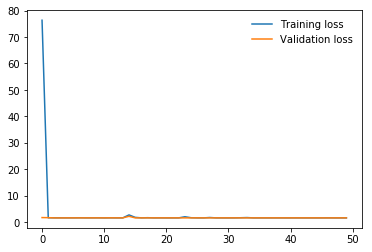

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
#load the best weights
state_dict = torch.load('weights.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
images, labels = next(iter(test_loader))
# Get the class probabilities
images, labels = images.to(device), labels.to(device).long()
ps = torch.exp(model(images.float()))

top_p, top_class = ps.topk(1, dim=1)
equals = top_class == labels.view(*top_class.shape)

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f' Test Accuracy: {accuracy.item()*100}%')

 Test Accuracy: 25.316455960273743%
